## Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [30]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [3]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [4]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [5]:
from collections import namedtuple
import itertools
from itertools import product

In [6]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [7]:
import PIL as pil
from PIL import Image, ImageDraw

In [8]:
import math

In [9]:
import sys
import os

In [10]:
import functools

In [11]:
import torch
import torchvision

In [12]:
from einops import *

In [13]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [14]:
import networkx as nx

In [15]:
from pathlib import Path

In [16]:
import umap
#Note: VERY HACKY: Manually fixed broken deps install.
import umap.plot
from umap import UMAP

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [17]:
import glasbey

## Load in our data

In [18]:
df_facenet = pd.read_pickle('df_facenet.pickle')

In [19]:
df_glcm = pd.read_pickle('df_glcm.pickle')

## What does a PCA of our Chestnut vs our Casuarina embeddings look like?

In [20]:
from sklearn.decomposition import PCA

In [21]:
chestnut_embeddings_df = df_facenet[df_facenet['src'].isin(['10May2021', '18Dec2020'])]
casuarina_embeddings_df = df_facenet[df_facenet['src'].isin(['183deg', '93deg'])]

In [22]:
X_chestnut_may = np.stack(chestnut_embeddings_df[chestnut_embeddings_df['src'] == '10May2021']['embedding'].apply(np.squeeze))
X_chestnut_december = np.stack(chestnut_embeddings_df[chestnut_embeddings_df['src'] == '18Dec2020']['embedding'].apply(np.squeeze))
X_casuarina = np.stack(casuarina_embeddings_df['embedding'].apply(np.squeeze))

In [23]:
chestnut_december_PCA = PCA(n_components=2).fit(X_chestnut_december)
chestnut_may_PCA = PCA(n_components=2).fit(X_chestnut_may)
casuarina_PCA = PCA(n_components=2).fit(X_casuarina)

In [24]:
X_chestnut_may_trans = chestnut_may_PCA.transform(X_chestnut_may)
X_chestnut_december_trans = chestnut_december_PCA.transform(X_chestnut_december)
X_casuarina_trans = casuarina_PCA.transform(X_casuarina)

In [25]:
post_pca = pd.DataFrame()
post_pca['pc1'] = np.concatenate((X_chestnut_may_trans[:,0],
                                  X_chestnut_december_trans[:,0],
                                  X_casuarina_trans[:,0]))
post_pca['pc2'] = np.concatenate((X_chestnut_may_trans[:,1],
                                  X_chestnut_december_trans[:,1],
                                  X_casuarina_trans[:,1]))
post_pca['source'] =\
    ['chestnut may'] * X_chestnut_may_trans.shape[0]\
    + ['chestnut december'] * X_chestnut_december_trans.shape[0]\
    + ['casuarina'] * X_casuarina_trans.shape[0]

<Axes: xlabel='pc1', ylabel='pc2'>

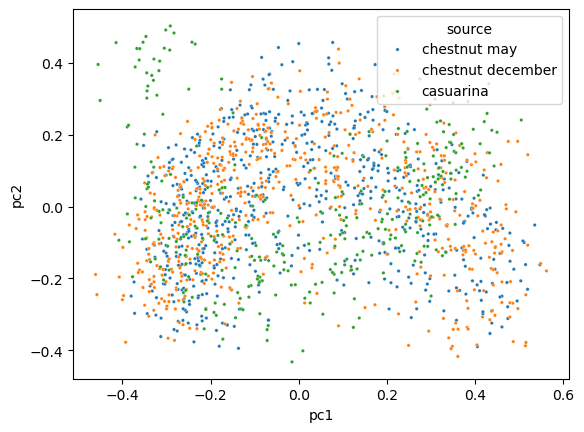

In [26]:
sns.scatterplot(post_pca,
                x='pc1', 
                y='pc2',
                hue='source',
                s=6)

## Decision boundaries on Chestnut data using GLCMs

In [27]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

In [31]:
chestnut_per_pixel_df = df_glcm[df_glcm['src'].isin(['10May2021', '18Dec2020'])]

In [32]:
species = list(chestnut_per_pixel_df['name'].unique())

In [33]:
X_glcm_may = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '10May2021'][[i for i in chestnut_per_pixel_df.columns if isinstance(i, tuple)]]
X_glcm_dec = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '18Dec2020'][[i for i in chestnut_per_pixel_df.columns if isinstance(i, tuple)]]

In [34]:
y_may = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '10May2021']['name']
y_dec = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '18Dec2020']['name']

In [35]:
le = LabelEncoder()
le.classes_ = np.asarray(species)

pca = PCA(n_components=2).set_output(transform='pandas')
pca_sc = StandardScaler().set_output(transform='pandas')
pca.fit(pca_sc.fit_transform(X_glcm_may))

lda = LinearDiscriminantAnalysis(n_components=2).set_output(transform='pandas')
lda_sc = StandardScaler().set_output(transform='pandas')
lda.fit(lda_sc.fit_transform(X_glcm_may), y_may)

pca_X_may = pca.transform(pca_sc.transform(X_glcm_may))
pca_X_dec = pca.transform(pca_sc.transform(X_glcm_dec))

lda_X_may = lda.transform(lda_sc.transform(X_glcm_may))
lda_X_dec = lda.transform(lda_sc.transform(X_glcm_dec))

pca_svc = SVC(C=10**5, gamma=3.236)
pca_svc.fit(pca_X_may, le.transform(y_may))

lda_svc = SVC(C=10**5, gamma=0.7943)
lda_svc.fit(lda_X_may, le.transform(y_may))

SVC(C=100000, gamma=0.7943)

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

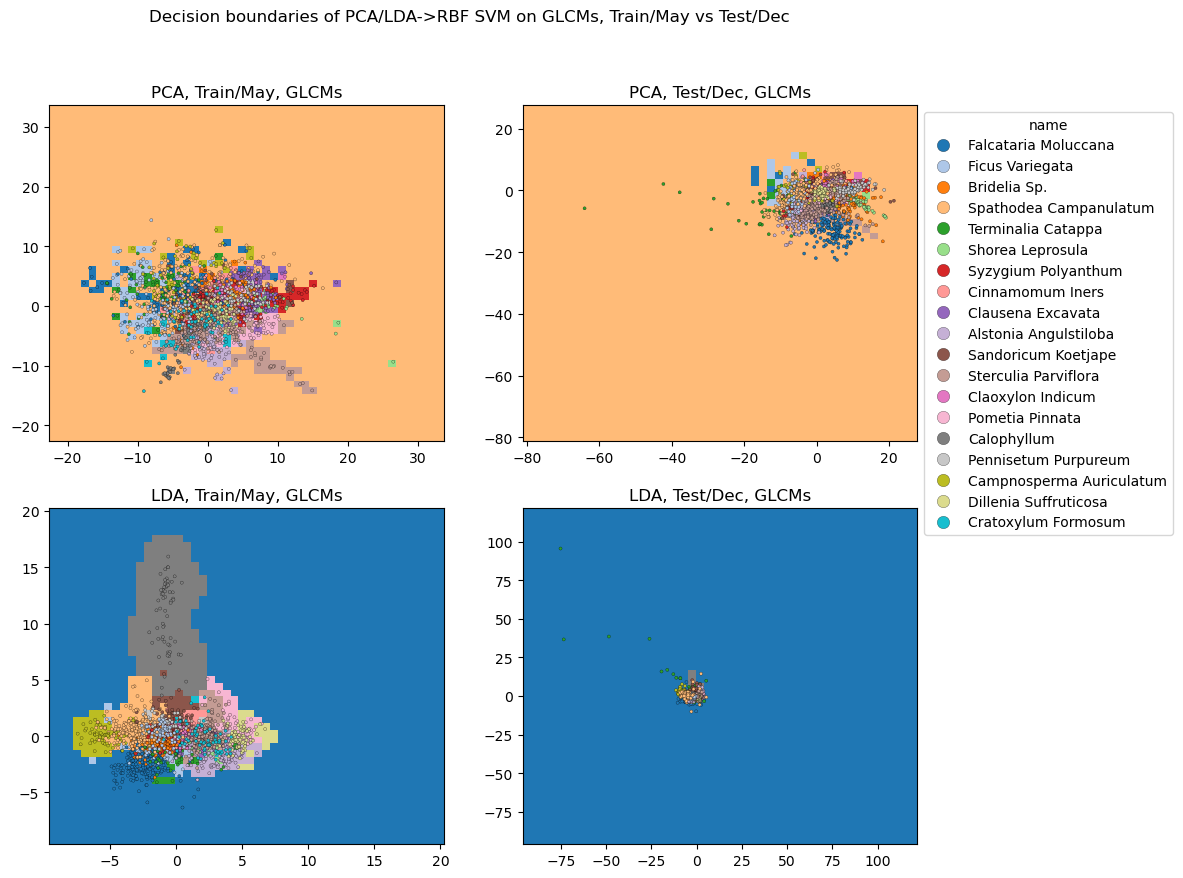

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(5.6*2, 4.8*2))
estimators = [pca_svc, pca_svc, lda_svc, lda_svc]
datas_X = [pca_X_may, pca_X_dec, lda_X_may, lda_X_dec]
datas_y = [y_may, y_dec, y_may, y_dec]
for estimator, X, y, ax_ in zip(estimators, datas_X, datas_y, ax.flatten()):
    _min = np.min(X)*1.25
    _max = np.max(X)*1.25

    mesh_x0, mesh_x1 = np.meshgrid(*((np.linspace(_min, _max),)*2))
    mesh_x = np.stack((mesh_x0.flatten(), mesh_x1.flatten()), axis=1)
    mesh_y = estimator.predict(mesh_x)
    C = [plt.cm.tab20(i) for i in mesh_y]
    C = np.asarray(C)
    C = C.reshape(mesh_x0.shape + (4,))
    
    ax_.pcolormesh(
        mesh_x0,
        mesh_x1,
        C,
    )

    sns.scatterplot(
        x=np.clip(X.iloc[:,0].to_numpy(), _min, _max),
        y=np.clip(X.iloc[:,1].to_numpy(), _min, _max),
        hue=y,
        hue_order=species,
        palette='tab20',
        legend=False if ax_ != ax[0][-1] else True,
        s=5,
        ax=ax_,
        edgecolor='black'
    )
    if ax_ == ax[0][-1]:
        sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1), markerscale=4)

ax[0][0].set_title('PCA, Train/May, GLCMs')
ax[0][1].set_title('PCA, Test/Dec, GLCMs')
ax[1][0].set_title('LDA, Train/May, GLCMs')
ax[1][1].set_title('LDA, Test/Dec, GLCMs')
fig.suptitle('Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

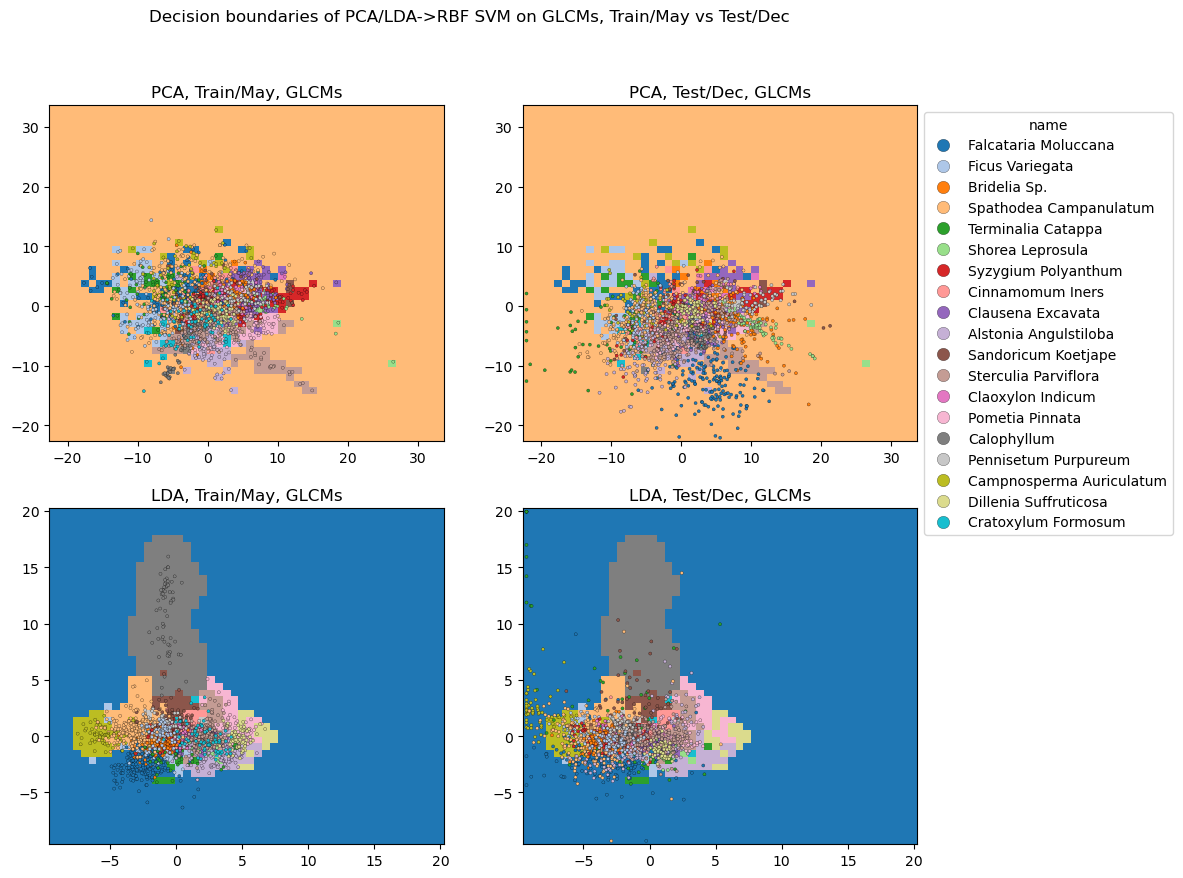

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(5.6*2, 4.8*2))
estimators = [pca_svc, pca_svc, lda_svc, lda_svc]
datas_X = [pca_X_may, pca_X_dec, lda_X_may, lda_X_dec]
datas_y = [y_may, y_dec, y_may, y_dec]
for estimator, X, y, ax_ in zip(estimators, datas_X, datas_y, ax.flatten()):
    if ax_ in ax[0]:
        _min = np.min(pca_X_may)*1.25
        _max = np.max(pca_X_may)*1.25
    elif ax_ in ax[1]:
        _min = np.min(lda_X_may)*1.25
        _max = np.max(lda_X_may)*1.25

    mesh_x0, mesh_x1 = np.meshgrid(*((np.linspace(_min, _max),)*2))
    mesh_x = np.stack((mesh_x0.flatten(), mesh_x1.flatten()), axis=1)
    mesh_y = estimator.predict(mesh_x)
    C = [plt.cm.tab20(i) for i in mesh_y]
    C = np.asarray(C)
    C = C.reshape(mesh_x0.shape + (4,))
    
    ax_.pcolormesh(
        mesh_x0,
        mesh_x1,
        C,
    )

    sns.scatterplot(
        x=np.clip(X.iloc[:,0].to_numpy(), _min, _max),
        y=np.clip(X.iloc[:,1].to_numpy(), _min, _max),
        hue=y,
        hue_order=species,
        palette='tab20',
        legend=False if ax_ != ax[0][-1] else True,
        s=5,
        ax=ax_,
        edgecolor='black'
    )
    if ax_ == ax[0][-1]:
        sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1), markerscale=4)

ax[0][0].set_title('PCA, Train/May, GLCMs')
ax[0][1].set_title('PCA, Test/Dec, GLCMs')
ax[1][0].set_title('LDA, Train/May, GLCMs')
ax[1][1].set_title('LDA, Test/Dec, GLCMs')
fig.suptitle('Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

## Decision boundaries on Chestnut data using Facenet

In [38]:
chestnut_facenet_df = df_facenet[df_facenet['src'].isin(['10May2021', '18Dec2020'])]

In [43]:
X_glcm_may = np.stack(chestnut_facenet_df[chestnut_facenet_df['src'] == '10May2021']['embedding'].apply(lambda x: x.flatten()))
X_glcm_dec = np.stack(chestnut_facenet_df[chestnut_facenet_df['src'] == '18Dec2020']['embedding'].apply(lambda x: x.flatten()))

In [44]:
y_may = chestnut_facenet_df[chestnut_facenet_df['src'] == '10May2021']['name']
y_dec = chestnut_facenet_df[chestnut_facenet_df['src'] == '18Dec2020']['name']

In [45]:
le = LabelEncoder()
le.classes_ = np.asarray(species)

pca = PCA(n_components=2).set_output(transform='pandas')
pca_sc = StandardScaler().set_output(transform='pandas')
pca.fit(pca_sc.fit_transform(X_glcm_may))

lda = LinearDiscriminantAnalysis(n_components=2).set_output(transform='pandas')
lda_sc = StandardScaler().set_output(transform='pandas')
lda.fit(lda_sc.fit_transform(X_glcm_may), y_may)

pca_X_may = pca.transform(pca_sc.transform(X_glcm_may))
pca_X_dec = pca.transform(pca_sc.transform(X_glcm_dec))

lda_X_may = lda.transform(lda_sc.transform(X_glcm_may))
lda_X_dec = lda.transform(lda_sc.transform(X_glcm_dec))

pca_svc = SVC(C=10**5, gamma=3.236)
pca_svc.fit(pca_X_may, le.transform(y_may))

lda_svc = SVC(C=10**5, gamma=0.7943)
lda_svc.fit(lda_X_may, le.transform(y_may))

SVC(C=100000, gamma=0.7943)

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

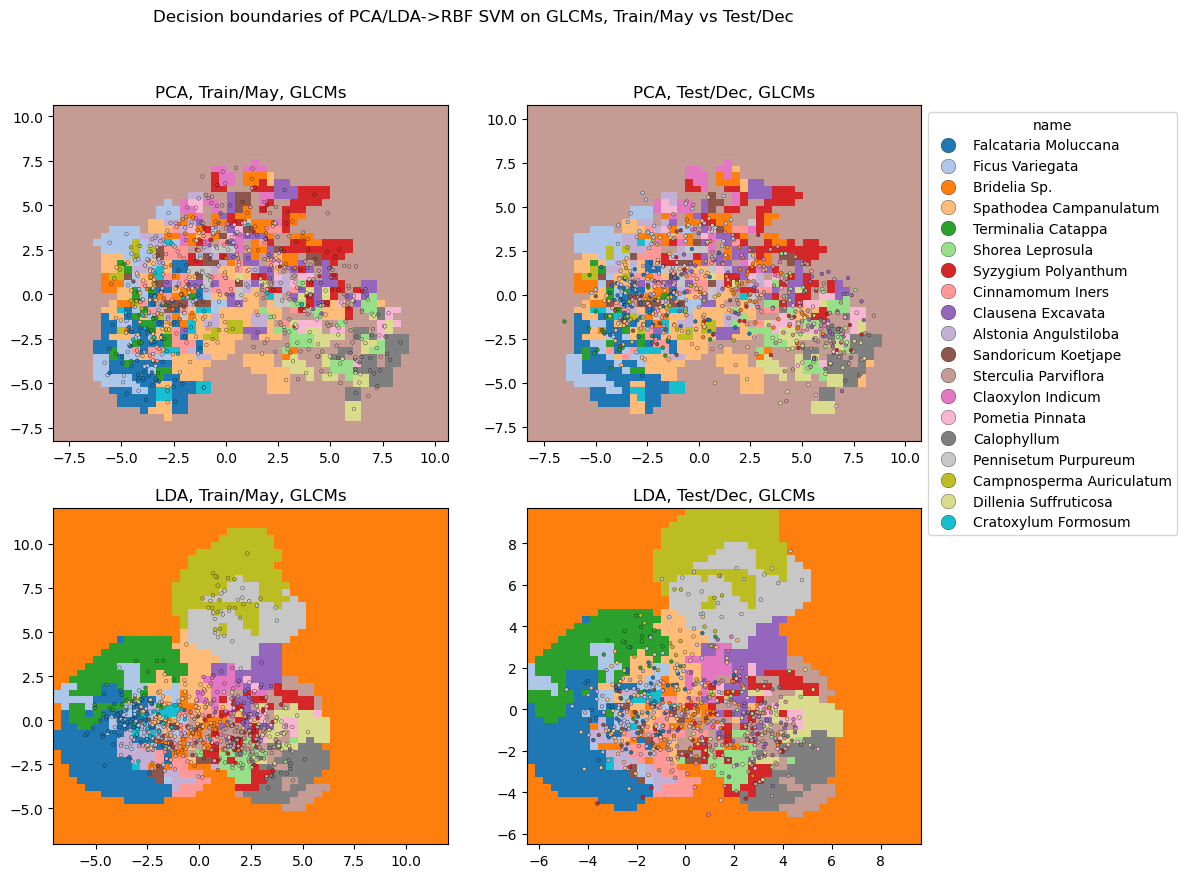

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(5.6*2, 4.8*2))
estimators = [pca_svc, pca_svc, lda_svc, lda_svc]
datas_X = [pca_X_may, pca_X_dec, lda_X_may, lda_X_dec]
datas_y = [y_may, y_dec, y_may, y_dec]
for estimator, X, y, ax_ in zip(estimators, datas_X, datas_y, ax.flatten()):
    _min = np.min(X)*1.25
    _max = np.max(X)*1.25

    mesh_x0, mesh_x1 = np.meshgrid(*((np.linspace(_min, _max),)*2))
    mesh_x = np.stack((mesh_x0.flatten(), mesh_x1.flatten()), axis=1)
    mesh_y = estimator.predict(mesh_x)
    C = [plt.cm.tab20(i) for i in mesh_y]
    C = np.asarray(C)
    C = C.reshape(mesh_x0.shape + (4,))
    
    ax_.pcolormesh(
        mesh_x0,
        mesh_x1,
        C,
    )

    sns.scatterplot(
        x=np.clip(X.iloc[:,0].to_numpy(), _min, _max),
        y=np.clip(X.iloc[:,1].to_numpy(), _min, _max),
        hue=y,
        hue_order=species,
        palette='tab20',
        legend=False if ax_ != ax[0][-1] else True,
        s=7,
        ax=ax_,
        edgecolor='black'
    )
    if ax_ == ax[0][-1]:
        sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1), markerscale=4)

ax[0][0].set_title('PCA, Train/May, GLCMs')
ax[0][1].set_title('PCA, Test/Dec, GLCMs')
ax[1][0].set_title('LDA, Train/May, GLCMs')
ax[1][1].set_title('LDA, Test/Dec, GLCMs')
fig.suptitle('Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

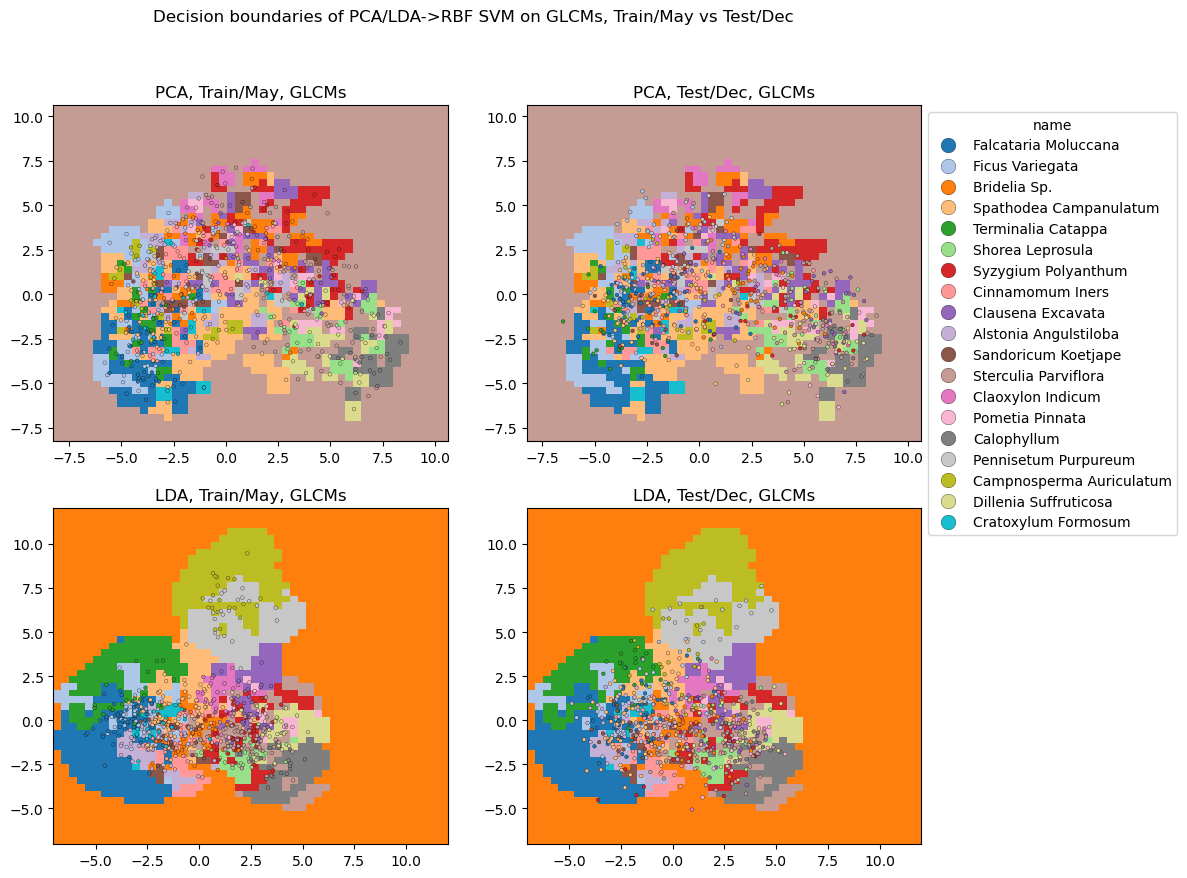

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(5.6*2, 4.8*2))
estimators = [pca_svc, pca_svc, lda_svc, lda_svc]
datas_X = [pca_X_may, pca_X_dec, lda_X_may, lda_X_dec]
datas_y = [y_may, y_dec, y_may, y_dec]
for estimator, X, y, ax_ in zip(estimators, datas_X, datas_y, ax.flatten()):
    if ax_ in ax[0]:
        _min = np.min(pca_X_may)*1.25
        _max = np.max(pca_X_may)*1.25
    elif ax_ in ax[1]:
        _min = np.min(lda_X_may)*1.25
        _max = np.max(lda_X_may)*1.25

    mesh_x0, mesh_x1 = np.meshgrid(*((np.linspace(_min, _max),)*2))
    mesh_x = np.stack((mesh_x0.flatten(), mesh_x1.flatten()), axis=1)
    mesh_y = estimator.predict(mesh_x)
    C = [plt.cm.tab20(i) for i in mesh_y]
    C = np.asarray(C)
    C = C.reshape(mesh_x0.shape + (4,))
    
    ax_.pcolormesh(
        mesh_x0,
        mesh_x1,
        C,
    )

    sns.scatterplot(
        x=np.clip(X.iloc[:,0].to_numpy(), _min, _max),
        y=np.clip(X.iloc[:,1].to_numpy(), _min, _max),
        hue=y,
        hue_order=species,
        palette='tab20',
        legend=False if ax_ != ax[0][-1] else True,
        s=7,
        ax=ax_,
        edgecolor='black'
    )
    if ax_ == ax[0][-1]:
        sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1), markerscale=4)

ax[0][0].set_title('PCA, Train/May, GLCMs')
ax[0][1].set_title('PCA, Test/Dec, GLCMs')
ax[1][0].set_title('LDA, Train/May, GLCMs')
ax[1][1].set_title('LDA, Test/Dec, GLCMs')
fig.suptitle('Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')